In [ ]:
!mkdir ~/.kaggle

In [ ]:
!echo '{"username":"YOUR_USER_NAME","key":"YOUR_KEY"}' > ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d glebsukhomlyn/small-subset-of-airbus-ship-segmentation-dataset -p /content/

100% 1.67G/1.67G [00:49<00:00, 42.1MB/s]
100% 1.67G/1.67G [00:49<00:00, 36.2MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/small-subset-of-airbus-ship-segmentation-dataset.zip", 'r')
zip_ref.extractall("/content/small-subset-of-airbus-ship-segmentation-dataset")
zip_ref.close()

# Install libraries and dataset

In [ ]:
import tensorflow as tf
import time
from tensorflow import keras
from keras import backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
import os

# Preprocess

In [ ]:
path_img_train = "small-subset-of-airbus-ship-segmentation-dataset/train_v2/"
path_img_val = "small-subset-of-airbus-ship-segmentation-dataset/val_v2/"
path_img_test = "small-subset-of-airbus-ship-segmentation-dataset/test_v2/"
path_y_train = "small-subset-of-airbus-ship-segmentation-dataset/train_ship_segmentations_v2.csv"
y_train = pd.read_csv(path_y_train)

In [ ]:
y_copy = y_train.copy()
y_copy['EncodedPixels'] += ' '
y_group = y_copy.groupby(by='ImageId')['EncodedPixels'].sum()
y_group = y_group.str.split(' ')

In [ ]:
def get_masks_batch(list_inds, group_data=y_group, use_bool=True):
    batch_size = len(list_inds)
    if use_bool:
      masks = np.zeros((768*768*batch_size),dtype=bool)
    else:
      masks = np.zeros((768*768*batch_size),dtype=np.uint8)
    df = group_data[list_inds]

    for i in range(df.shape[0]):
        arr = np.array(df.iloc[i])
        if arr.size>=2:
          arr = arr[:-1]
          arr = arr.reshape(arr.size//2,2)
          for inds in arr:
              masks[int(inds[0])+768*768*i:int(inds[0])+768*768*i+int(inds[1])] = 1

    masks = masks.reshape(batch_size,768,768)
    for j in range(batch_size):
        masks[j] = masks[j].T
    return masks

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):

  def __init__(self, df, path_data, batch_size, shuffle=True, use_bool=True, resize=False, height=256, width=256):
    self.df = df.copy()
    self.path_data = path_data
    self.im_list = np.array(os.listdir(path_data))
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.use_bool = use_bool
    self.resize = resize
    self.height = height
    self.width = width
    self.n = self.im_list.size

  def on_epoch_end(self):
    if self.shuffle:
      rng = np.random.default_rng()
      rng.shuffle(self.im_list)

  def __getitem__(self, index):
    batch = self.im_list[index*self.batch_size:(index+1)*self.batch_size]
    l_masks = tf.constant(get_masks_batch(batch, self.df, self.use_bool))[..., tf.newaxis]
    l_imgs = []
    for img_name in batch:
      img = tf.io.read_file(self.path_data+img_name)
      img = tf.image.decode_png(img, channels=3)
      img = tf.image.convert_image_dtype(img, tf.float32)
      l_imgs.append(img)
    l_imgs = tf.stack(l_imgs)
    if self.resize:
      l_imgs = tf.image.resize(l_imgs, (self.height, self.width), method='nearest')
      l_masks = tf.image.resize(l_masks, (self.height, self.width), method='nearest')
    return l_imgs,l_masks

  def __len__(self):
    return self.n // self.batch_size

In [ ]:
traingen = CustomDataGen(y_group, path_img_train, 32, use_bool=False, resize=True, height=128, width=128)
batch = 0
imgs, masks = traingen[batch]

In [ ]:
def plot(images, list_masks, sample=0, num_pict=10, comb=False):
  if comb:
    fig, arr = plt.subplots(2*num_pict, 2, figsize=(12, 12*num_pict))
  else:
    fig, arr = plt.subplots(num_pict, 2, figsize=(12, 6*num_pict))
  for i in range(num_pict):
    img = images.numpy()[sample+i]
    h,w,_ = img.shape
    mask = list_masks.numpy()[sample+i]
    ind = 2*i if comb else i
    arr[ind,0].imshow(img)
    arr[ind,0].set_title('Image {}'.format(sample+i))
    arr[ind,1].imshow(mask)
    arr[ind,1].set_title('Segmentation {}'.format(sample+i))
    if comb:
      arr[2*i+1,0].imshow(img)
      arr[2*i+1,0].set_title('Image {}'.format(sample+i))
      img_mask = img.copy()
      img_mask = img_mask.reshape(h*w, 3)
      mask = mask.flatten()
      img_mask[mask] = 1.0
      img_mask = img_mask.reshape(h,w,3)
      arr[2*i+1,1].imshow(img_mask)
      arr[2*i+1,1].set_title('Segmentation+Image {}'.format(sample+i))
      mask = mask.reshape(h,w)

In [ ]:
sample = 0           # start sample
num_pict = 25          # number of pictures
plot(imgs, masks, sample, num_pict)

Output hidden; open in https://colab.research.google.com to view.

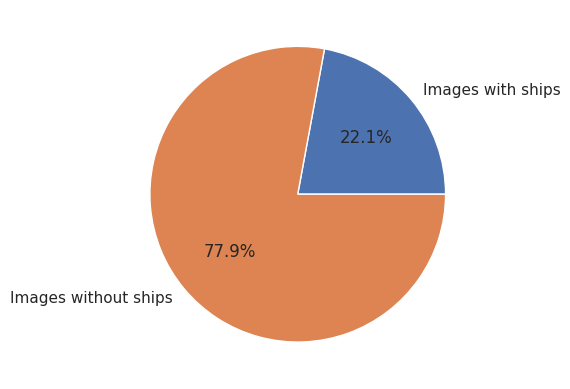

In [ ]:
ids_vals = y_train.groupby(by='ImageId')['EncodedPixels'].count()
no_ships = np.round((ids_vals==0).mean(),4)

fig, ax = plt.subplots()
sizes = [1-no_ships, no_ships]
pl_t = ax.pie(sizes, labels=['Images with ships', 'Images without ships'], autopct='%1.1f%%')

We can see some imbalance in data( approximately 78% of the images do not contain any ships).However this is not too large imbalance in data so ordinary bce (binary cross entropy) as a loss function can be used.

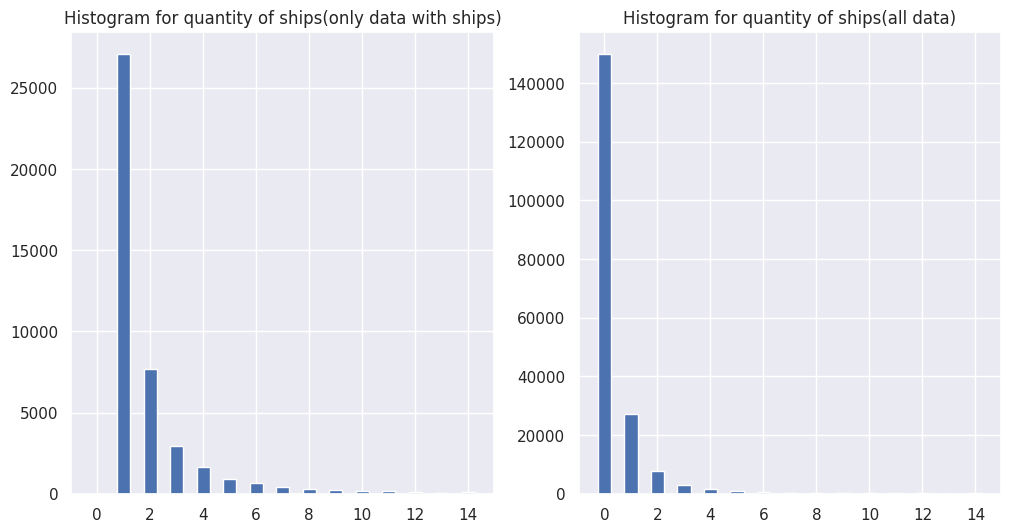

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].set_title('Histogram for quantity of ships(only data with ships)', fontsize=12)
res1 = ax[0].hist(ids_vals[ids_vals!=0], bins=np.arange(ids_vals.max()+1), rwidth=0.5, align='left')
ax[1].set_title('Histogram for quantity of ships(all data)', fontsize=12)
res2 = ax[1].hist(ids_vals, bins=np.arange(ids_vals.max()+1), rwidth=0.5, align='left')

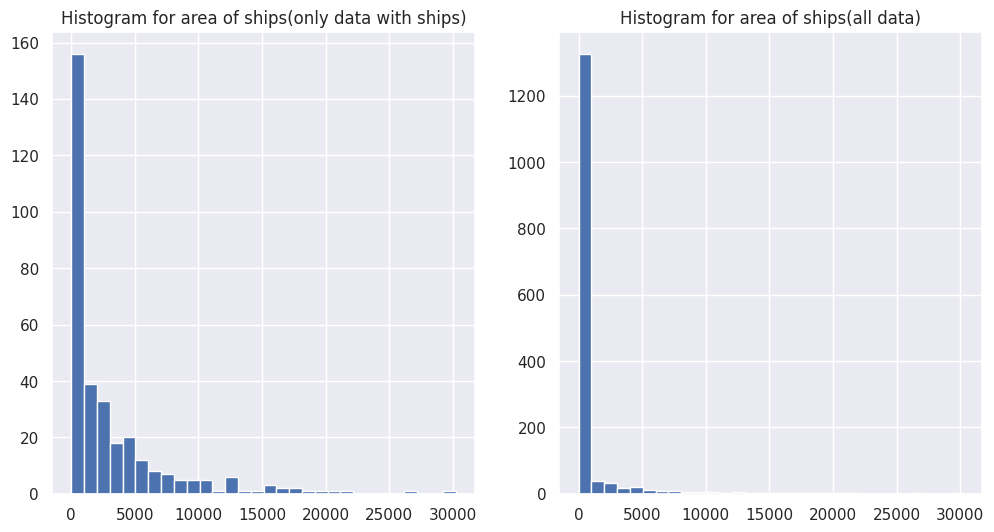

In [ ]:
areas = []
for el in y_group:
  arr = np.array(el)
  if arr.size>=2:
    area = np.int32(arr[:-1])
    area = area.reshape(area.size//2,2)[:,1].sum()
  else:
    area = 0
  areas.append(area)
areas = np.array(areas)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].set_title('Histogram for area of ships(only data with ships)', fontsize=12)
res1 = ax[0].hist(areas[areas!=0], bins=30)
ax[1].set_title('Histogram for area of ships(all data)', fontsize=12)
res2 = ax[1].hist(areas, bins=30)

Last two histograms - distributions of the number of ships and the total area of ​​ships per image.
From these histograms it follows that the smaller the number of ships or the smaller the total area, the higher the probability of meeting the corresponding ships. This may indicate some data imbalance and it is possible that together with the usual bce bfce (binary focal cross entropy) should also be tested.

quantity of pixels that meet condition = 192556 (100.0%)
mean area per picture = 665.223950435198
std of the area per picture = 2383.075687642202


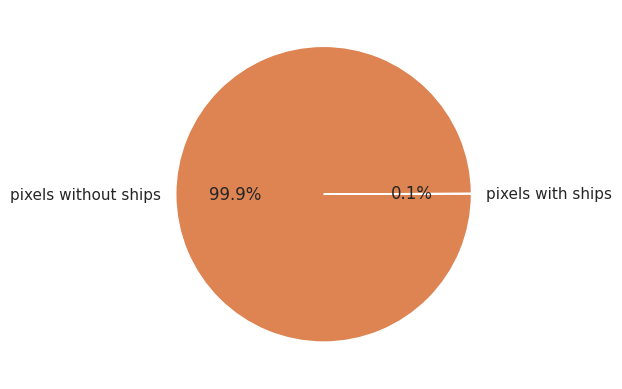

In [ ]:
condition = True
areas_c = areas[condition].copy()
pics_ships = areas_c.sum()/(areas_c.size*768*768)
pics_no_ships = 1-pics_ships
print('quantity of pixels that meet condition = {} ({:.{}f}%)'.format(areas_c.size, 100*areas_c.size/areas.size, 1))

fig, ax = plt.subplots()
sizes = [pics_ships, pics_no_ships]
pl_t = ax.pie(sizes, labels=['pixels with ships', 'pixels without ships'], autopct='%1.1f%%')
print('mean area per picture = {}'.format(areas_c.mean()))
print('std of the area per picture = {}'.format(areas_c.std()))

The pie chart of pixels shows that only 0.1% of all pixels belong to some ship but this is unlikely to indicate a large imbalance in the data
because many pixels are from the same image and thus there will be some relationship between them and therefore each pixel cannot be treated as an independent instance of data.

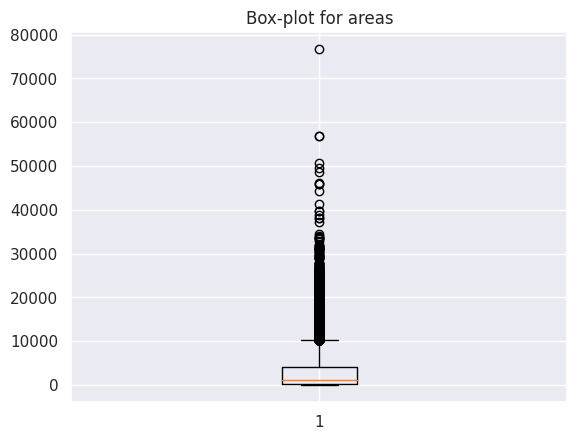

In [ ]:
plt.boxplot(areas_c[areas_c>0])
d = plt.title('Box-plot for areas')

Here is boxplot only for images with ships. If you apply a boxplot, it will treat images with a large number of ships or a large area as outliers, but they are actually quite useful images.